# SF task: Known unknowns

In this exercise we would like you to:

- build SOTA solution for image classification,
- find a way to find out if your model works really bad


### SOTA CNN Solution for image classification.

In this task you need to build a CNN model which:

- will be trained on a [`cifar 10`](https://www.cs.toronto.edu/~kriz/cifar.html), 
- will have a stem like in `ResNet 50`, 
- will have at least one skip connection,

A properly solved task should consist of:
- a code cell with a `stem` definition with appropriate citation and image added,
- a code cell with a skip-connection definition with appropriate image added,
- training a model on `CIFAR 10` which achieves at least 70% of accuracy on a test set from `CIFAR 10`.


### Diving into knowing about what do we don't know

The second task is to assess the certainty of your classifier. Your task is to propose a certainty metric which based on your model - will make prediction if a given prediction can be trusted or not.

A properly solved task should consist of:
- a code cell with definition of your metric and a text cell with its explaination,
- a code cell with a histogram of this metric for both properly classified and misclassified examples from CIFAR 10 dataset (histogram should compare distribution of your metric on properly and wrongly classified data).


### Code wrap up: 

Please wrap up your model in the following class as it will be tested against additional dataset:


    class Model:
        
        def predict(self, input_array: np.ndarray) -> np.ndarray:
            # Given a batch of examples return a batch of predicted classes.

        def certainty(self, input_array: np.ndarray) -> np.ndarray:
            # Given a batch of examples return a batch of certainty levels.

# Solution task 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision.datasets import CIFAR10

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image

from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

BATCH_SIZE = 128
NO_EPOCHS = 20
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
device

'cpu'

In [2]:
# Dimensions of images were kept
transform = Compose([
  ToTensor(),
  Normalize( 
      mean=[0.4914, 0.4822, 0.4465], # Normalization for faster convergence
      std=[0.2023, 0.1994, 0.2010], # Calculated values found on the Internet
  )
])

In [3]:
# Could split train for train and valid but I will keep it simple.
# In this case using test as validation dataset

train = CIFAR10(
    "./sample_data/cifar_train", 
    train=True,
    download=True, 
    transform=transform,
)

test = CIFAR10(
    "./sample_data/cifar_test", 
    train=False,
    download=True, 
    transform=transform,
)
if device == 'cuda':
  train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, pin_memory_device=device)
  test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, pin_memory_device=device)
else:
  train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./sample_data/cifar_train/cifar-10-python.tar.gz to ./sample_data/cifar_train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./sample_data/cifar_test/cifar-10-python.tar.gz to ./sample_data/cifar_test


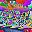

In [ ]:
to_pil_image(train[4][0])

## Stem



Original Resnet stem consists of convolution block with kernel size of 7 and MaxPooling layer [source](https://arxiv.org/pdf/1512.03385v1.pdf) <br>
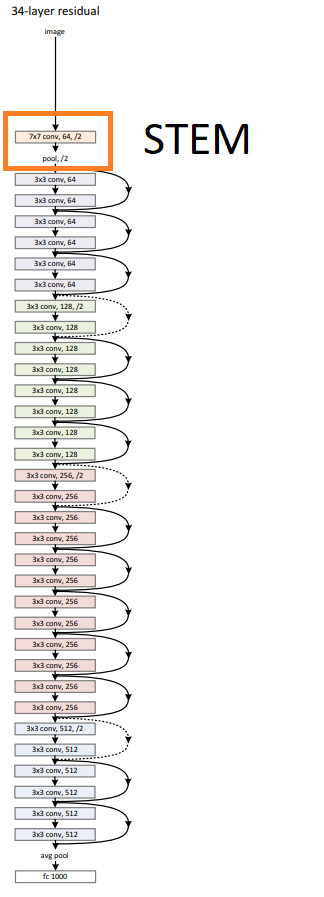

---


Below We can see PyTorch implementation for Resnet50 Stem. 

In [4]:
# Stem from Resnet50
class Stem(nn.Module):
  
  def __init__(self):
    super(Stem, self).__init__()

    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.batch_norm1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU() # 64x16x16
    self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
    # Output 64x8x8 

  def forward(self, x):
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.relu(x)
    x = self.max_pool(x)

    return x

summary(Stem().to(device), (3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
Total params: 9,536
Trainable params: 9,536
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.41
Params size (MB): 0.04
Estimated Total Size (MB): 0.45
----------------------------------------------------------------


## Model blocks

Each Block of final model contains skip connection. During building network I was inspired by ResNet, ResNext and Inception architectures.


In [5]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, channels_expand: int, stride_2nd: int, additional_conv: bool):
    super(ResidualBlock, self).__init__()

    self.additional_conv = additional_conv
    self.stride_2nd = stride_2nd

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.batch_norm1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride_2nd, padding=1)
    self.batch_norm2 = nn.BatchNorm2d(out_channels)

    self.conv3 = nn.Conv2d(out_channels, out_channels*channels_expand, kernel_size=1, stride=1, padding=0)
    self.batch_norm3 = nn.BatchNorm2d(out_channels*channels_expand)

    self.res_conv = nn.Conv2d(out_channels, out_channels*channels_expand, kernel_size=1, stride=stride_2nd, padding=0)
    self.res_batch_norm = nn.BatchNorm2d(out_channels*channels_expand)
    self.relu = nn.ReLU()


  def forward(self, x):
    res_connection = x.clone()
    if self.additional_conv:
      res_connection = self.res_batch_norm(self.res_conv(res_connection))
    else:
      pass
    x = self.relu(self.batch_norm1(self.conv1(x)))
    x = self.relu(self.batch_norm2(self.conv2(x)))
    x = self.batch_norm3(self.conv3(x))

    x += res_connection
    x = self.relu(x)

    return x

summary(ResidualBlock(64,64,2,2, True).to(device), input_size=(64,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 4, 4]           8,320
       BatchNorm2d-2            [-1, 128, 4, 4]             256
            Conv2d-3             [-1, 64, 8, 8]           4,160
       BatchNorm2d-4             [-1, 64, 8, 8]             128
              ReLU-5             [-1, 64, 8, 8]               0
            Conv2d-6             [-1, 64, 4, 4]          36,928
       BatchNorm2d-7             [-1, 64, 4, 4]             128
              ReLU-8             [-1, 64, 4, 4]               0
            Conv2d-9            [-1, 128, 4, 4]           8,320
      BatchNorm2d-10            [-1, 128, 4, 4]             256
             ReLU-11            [-1, 128, 4, 4]               0
Total params: 58,496
Trainable params: 58,496
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/ba

In [6]:
class ResnextBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int):
    super(ResnextBlock, self).__init__()

    self.conv1_1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.conv1_2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    self.batch_norm1_1 = nn.BatchNorm2d(out_channels)
    self.batch_norm1_2 = nn.BatchNorm2d(out_channels)

    self.conv2_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.conv2_2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

    self.batch_norm2_1 = nn.BatchNorm2d(out_channels)
    self.batch_norm2_2 = nn.BatchNorm2d(out_channels)

    self.conv3_1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.conv3_2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    self.batch_norm3_1 = nn.BatchNorm2d(out_channels)
    self.batch_norm3_2 = nn.BatchNorm2d(out_channels)

    self.relu = nn.ReLU()


  def forward(self, x):
    second_path = x.clone()

    x = self.relu(self.batch_norm1_1(self.conv1_1(x)))
    x = self.relu(self.batch_norm2_1(self.conv2_1(x)))
    x = self.batch_norm3_1(self.conv3_1(x))

    second_path = self.relu(self.batch_norm1_1(self.conv1_1(second_path)))
    second_path = self.relu(self.batch_norm2_1(self.conv2_1(second_path)))
    second_path = self.batch_norm3_1(self.conv3_1(second_path))

    x += second_path
    x = self.relu(x)

    return x

summary(ResnextBlock(64,64).to(device), input_size=(64,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]           4,160
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]           4,160
       BatchNorm2d-8             [-1, 64, 8, 8]             128
            Conv2d-9             [-1, 64, 8, 8]           4,160
      BatchNorm2d-10             [-1, 64, 8, 8]             128
             ReLU-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,928
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [7]:
class MixedBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int):
    super(MixedBlock, self).__init__()

    self.branch1 = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
    )

    self.branch2 = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(in_channels, out_channels, kernel_size=(1,3)),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(in_channels, out_channels, kernel_size=(3,1), padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
    )

    self.addition = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
    ) 


  def forward(self, x):
    res = x.clone()

    branch1 = self.branch1(x)
    branch2 = self.branch2(x)

    addition = branch1+branch2

    x = addition+res

    return x


summary(MixedBlock(512,512).to(device), input_size=(512,4,4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 512, 4, 4]         262,656
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
            Conv2d-4            [-1, 512, 4, 4]         262,656
       BatchNorm2d-5            [-1, 512, 4, 4]           1,024
              ReLU-6            [-1, 512, 4, 4]               0
            Conv2d-7            [-1, 512, 4, 2]         786,944
       BatchNorm2d-8            [-1, 512, 4, 2]           1,024
              ReLU-9            [-1, 512, 4, 2]               0
           Conv2d-10            [-1, 512, 4, 4]         786,944
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
             ReLU-12            [-1, 512, 4, 4]               0
Total params: 2,103,296
Trainable params: 2,103,296
Non-trainable params: 0
---------------------------

In [14]:
class FinalModel(nn.Module):
  def __init__(self, num_classes):
    super(FinalModel, self).__init__()

    self.stem = Stem()
    self.conv_block1 = ResidualBlock(64, 64, 1, 1, additional_conv=False)
    self.conv_expansion_block1 = ResidualBlock(64, 64, 2, 1, additional_conv=True)

    self.identitex_block = ResnextBlock(64,64)
    self.identitex_expanded_block1 = ResnextBlock(128,128)

    self.mixed_block1 = MixedBlock(64,64)
    self.mixed_block2 = MixedBlock(128,128)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.lin = nn.Linear(128, num_classes)


  def forward(self, x):

    x = self.stem(x)

    x = self.conv_block1(x)

    x = self.identitex_block(x)
    x = self.mixed_block1(x)

    x = self.conv_expansion_block1(x)

    x = self.identitex_expanded_block1(x)
    x = self.mixed_block2(x)

    x = self.avgpool(x)

    x = x.view(x.size(0), -1)
    
    x = self.lin(x)

    return x


summary(FinalModel(10).to(device), (3,32,32))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
              Stem-5             [-1, 64, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]           4,160
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
      BatchNorm2d-10             [-1, 64, 8, 8]             128
             ReLU-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]           4,160
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [ ]:
### Model class which was used for testing different architectures 
### It turns out to be too complicated for 32x32 images 
### Could be better after resizing images

# class TryOutModel(nn.Module):
#   def __init__(self, num_classes):
#     super(TryOutModel, self).__init__()

#     self.stem = Stem()
#     self.conv_block1 = ResidualBlock(64, 64, 1, 1, additional_conv=False)
#     self.conv_expansion_block1 = ResidualBlock(64, 64, 2, 1, additional_conv=True)
#     self.conv_expansion_block2 = ResidualBlock(128, 128, 2, 1, additional_conv=True)
#     self.conv_expansion_block3 = ResidualBlock(256, 256, 2, 1, additional_conv=True)
#     self.conv_block2 = ResidualBlock(256, 256, 1, 1, additional_conv=False)

#     self.identitex_block = ResnextBlock(64,64)
#     self.identitex_expanded_block1 = ResnextBlock(128,128)
#     self.identitex_expanded_block2 = ResnextBlock(256,256)

#     self.mixed_block1 = MixedBlock(64,64)
#     self.mixed_block2 = MixedBlock(128,128)


#     self.avgpool = nn.AdaptiveAvgPool2d((1,1))
#     self.lin = nn.Linear(128, num_classes)

#   def forward(self, x):

#     x = self.stem(x)

#     x = self.conv_block1(x)

#     x = self.identitex_block(x)
#     x = self.mixed_block1(x)
    # x = self.identitex_block(x)

    # x = self.conv_expansion_block1(x)

    # x = self.identitex_expanded_block1(x)
    # x = self.mixed_block2(x)

    # x = self.identitex_expanded_block1(x)
    # x = self.identitex_expanded_block1(x)

    # x = self.conv_expansion_block2(x)

    # x = self.identitex_expanded_block2(x)
    # x = self.identitex_expanded_block2(x)

    # x = self.conv_expansion_block3(x)

    # x = self.mixed_block(x)
    # x = self.mixed_block(x)

#     x = self.avgpool(x)

#     x = x.view(x.size(0), -1)
    
#     x = self.lin(x)

#     return x


# summary(TryOutModel(10).to(device), (3,32,32))  

## Training CNN

In [ ]:
model = FinalModel(10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=0.01, 
    weight_decay = 0.001, 
    momentum = 0.9
) 

writer = SummaryWriter('runs/model_2')

In [ ]:
for epoch in tqdm(range(NO_EPOCHS)):
  # Main training part

  correct = 0
  epoch_loss = 0
  
  for images, labels in train_loader:  
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    loss = criterion(outputs, labels)
    epoch_loss += loss.item() * images.size(0)

    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_loss /= len(train_loader.dataset)
  tqdm.write(f'Epoch [{epoch+1}/{NO_EPOCHS}], Train Loss: {epoch_loss:.2f}, Train Acc: {100*correct/len(train_loader.dataset):.2f} %')
  
  # Evaluation Part
  with torch.no_grad():
    
    correct_test = 0
    epoch_loss_test = 0

    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      epoch_loss_test += loss.item() * images.size(0)

      _, predicted = torch.max(outputs.data, 1)
      correct_test += (predicted == labels).sum().item()

    epoch_loss_test /= len(test_loader.dataset)
    tqdm.write(f'Epoch [{epoch+1}/{NO_EPOCHS}], Test Loss: {epoch_loss_test:.2f}, Test Acc: {100*correct_test/len(test_loader.dataset):.2f} %')

  writer.add_scalars('loss', {
      'training_loss': round(epoch_loss, 2),
      'testing_loss':  round(epoch_loss_test, 2),
    }, epoch+1 )
  
  writer.add_scalars('accuracy', {
    'training_acc': round(100*correct/len(train_loader.dataset), 2),
    'testing_acc':  round(100*correct_test/len(test_loader.dataset), 2),
  }, epoch+1 )


  0%|          | 0/20 [00:17<?, ?it/s]

Epoch [1/20], Train Loss: 1.45, Train Acc: 46.60 %


  5%|▌         | 1/20 [00:19<06:17, 19.87s/it]

Epoch [1/20], Test Loss: 1.20, Test Acc: 56.99 %


  5%|▌         | 1/20 [00:36<06:17, 19.87s/it]

Epoch [2/20], Train Loss: 1.06, Train Acc: 62.27 %


 10%|█         | 2/20 [00:39<05:50, 19.48s/it]

Epoch [2/20], Test Loss: 0.94, Test Acc: 66.63 %


 10%|█         | 2/20 [00:56<05:50, 19.48s/it]

Epoch [3/20], Train Loss: 0.87, Train Acc: 69.46 %


 15%|█▌        | 3/20 [00:59<05:40, 20.00s/it]

Epoch [3/20], Test Loss: 0.83, Test Acc: 70.78 %


 15%|█▌        | 3/20 [01:16<05:40, 20.00s/it]

Epoch [4/20], Train Loss: 0.76, Train Acc: 73.34 %


 20%|██        | 4/20 [01:19<05:17, 19.84s/it]

Epoch [4/20], Test Loss: 0.79, Test Acc: 71.95 %


 20%|██        | 4/20 [01:36<05:17, 19.84s/it]

Epoch [5/20], Train Loss: 0.68, Train Acc: 76.23 %


 25%|██▌       | 5/20 [01:38<04:55, 19.70s/it]

Epoch [5/20], Test Loss: 0.78, Test Acc: 73.04 %


 25%|██▌       | 5/20 [01:55<04:55, 19.70s/it]

Epoch [6/20], Train Loss: 0.61, Train Acc: 78.58 %


 30%|███       | 6/20 [01:58<04:34, 19.58s/it]

Epoch [6/20], Test Loss: 0.71, Test Acc: 75.54 %


 30%|███       | 6/20 [02:15<04:34, 19.58s/it]

Epoch [7/20], Train Loss: 0.57, Train Acc: 80.06 %


 35%|███▌      | 7/20 [02:17<04:14, 19.54s/it]

Epoch [7/20], Test Loss: 0.70, Test Acc: 76.30 %


 35%|███▌      | 7/20 [02:34<04:14, 19.54s/it]

Epoch [8/20], Train Loss: 0.52, Train Acc: 81.70 %


 40%|████      | 8/20 [02:36<03:53, 19.48s/it]

Epoch [8/20], Test Loss: 0.69, Test Acc: 76.42 %


 40%|████      | 8/20 [02:53<03:53, 19.48s/it]

Epoch [9/20], Train Loss: 0.48, Train Acc: 82.95 %


 45%|████▌     | 9/20 [02:56<03:34, 19.47s/it]

Epoch [9/20], Test Loss: 0.72, Test Acc: 75.67 %


 45%|████▌     | 9/20 [03:13<03:34, 19.47s/it]

Epoch [10/20], Train Loss: 0.47, Train Acc: 83.57 %


 50%|█████     | 10/20 [03:16<03:15, 19.54s/it]

Epoch [10/20], Test Loss: 0.67, Test Acc: 77.31 %


 50%|█████     | 10/20 [03:33<03:15, 19.54s/it]

Epoch [11/20], Train Loss: 0.44, Train Acc: 84.55 %


 55%|█████▌    | 11/20 [03:35<02:56, 19.59s/it]

Epoch [11/20], Test Loss: 0.69, Test Acc: 77.35 %


 55%|█████▌    | 11/20 [03:53<02:56, 19.59s/it]

Epoch [12/20], Train Loss: 0.41, Train Acc: 85.45 %


 60%|██████    | 12/20 [03:56<02:39, 19.93s/it]

Epoch [12/20], Test Loss: 0.68, Test Acc: 77.21 %


 60%|██████    | 12/20 [04:13<02:39, 19.93s/it]

Epoch [13/20], Train Loss: 0.38, Train Acc: 86.48 %


 65%|██████▌   | 13/20 [04:16<02:18, 19.83s/it]

Epoch [13/20], Test Loss: 0.69, Test Acc: 77.52 %


 65%|██████▌   | 13/20 [04:33<02:18, 19.83s/it]

Epoch [14/20], Train Loss: 0.37, Train Acc: 87.02 %


 70%|███████   | 14/20 [04:35<01:58, 19.74s/it]

Epoch [14/20], Test Loss: 0.68, Test Acc: 77.70 %


 70%|███████   | 14/20 [04:52<01:58, 19.74s/it]

Epoch [15/20], Train Loss: 0.36, Train Acc: 87.43 %


 75%|███████▌  | 15/20 [04:55<01:38, 19.70s/it]

Epoch [15/20], Test Loss: 0.70, Test Acc: 77.15 %


 75%|███████▌  | 15/20 [05:12<01:38, 19.70s/it]

Epoch [16/20], Train Loss: 0.34, Train Acc: 88.08 %


 80%|████████  | 16/20 [05:14<01:18, 19.68s/it]

Epoch [16/20], Test Loss: 0.71, Test Acc: 77.61 %


 80%|████████  | 16/20 [05:31<01:18, 19.68s/it]

Epoch [17/20], Train Loss: 0.33, Train Acc: 88.45 %


 85%|████████▌ | 17/20 [05:34<00:58, 19.65s/it]

Epoch [17/20], Test Loss: 0.68, Test Acc: 77.88 %


 85%|████████▌ | 17/20 [05:51<00:58, 19.65s/it]

Epoch [18/20], Train Loss: 0.31, Train Acc: 88.93 %


 90%|█████████ | 18/20 [05:53<00:39, 19.62s/it]

Epoch [18/20], Test Loss: 0.73, Test Acc: 77.28 %


 90%|█████████ | 18/20 [06:10<00:39, 19.62s/it]

Epoch [19/20], Train Loss: 0.31, Train Acc: 89.17 %


 95%|█████████▌| 19/20 [06:13<00:19, 19.61s/it]

Epoch [19/20], Test Loss: 0.70, Test Acc: 77.76 %


 95%|█████████▌| 19/20 [06:30<00:19, 19.61s/it]

Epoch [20/20], Train Loss: 0.29, Train Acc: 89.96 %


100%|██████████| 20/20 [06:33<00:00, 19.67s/it]

Epoch [20/20], Test Loss: 0.71, Test Acc: 78.17 %


In [ ]:
writer.flush()
writer.close()

In [8]:
import os
import sys
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# model_path = '/content/gdrive/MyDrive/cnn_model/model'

# torch.save(model.state_dict(), model_path)

During first training I saw that something bad is going on with loss on test set. It turned out that data from DataLoaders were not properly shuffled.


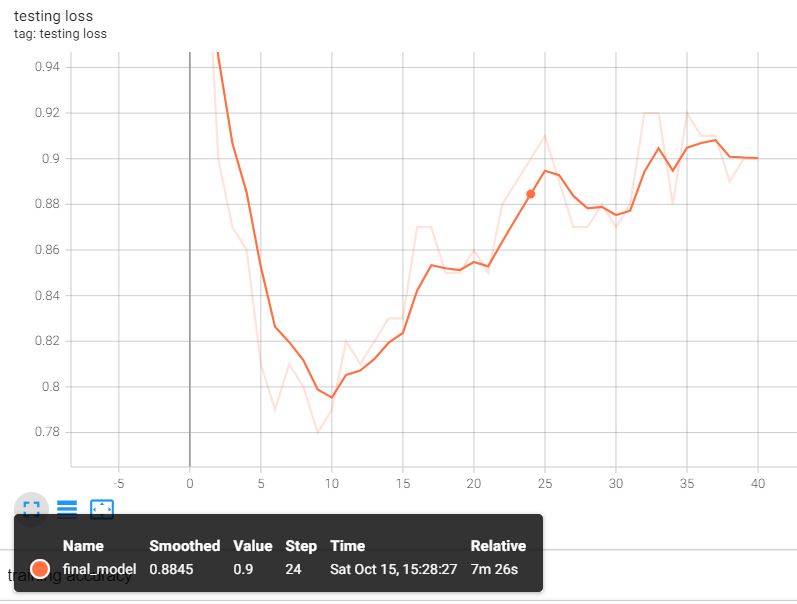

## Score

Best model after fixing an issue with unshuffled data got an accuracy of +/- 77% on the test set <br>

Here is the link to download ready model: https://drive.google.com/drive/folders/1g0v9bGi7oNA3-xIUgR8Y5kEV34DSrBVw?usp=sharing


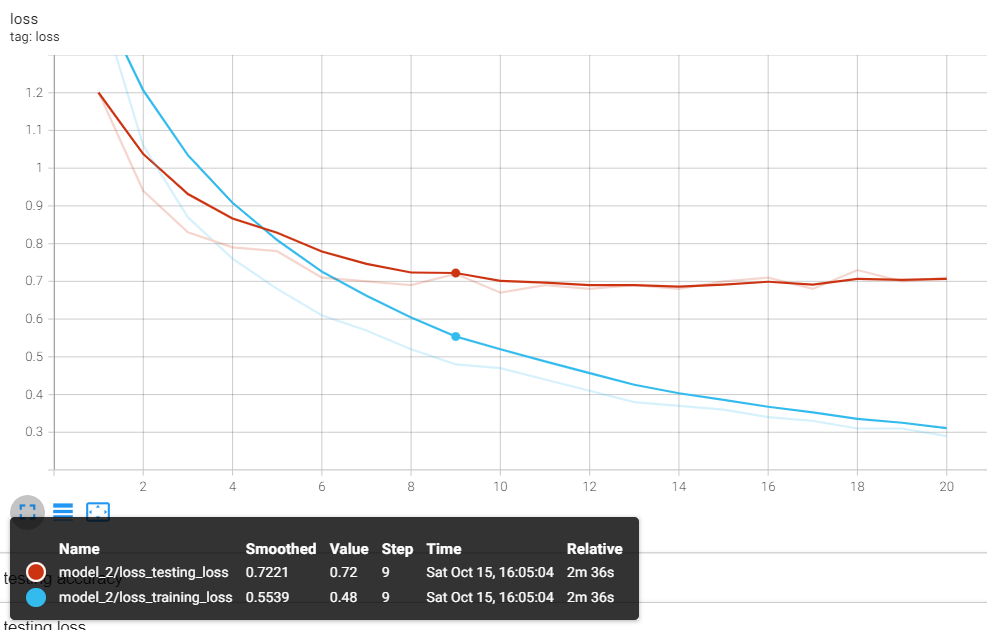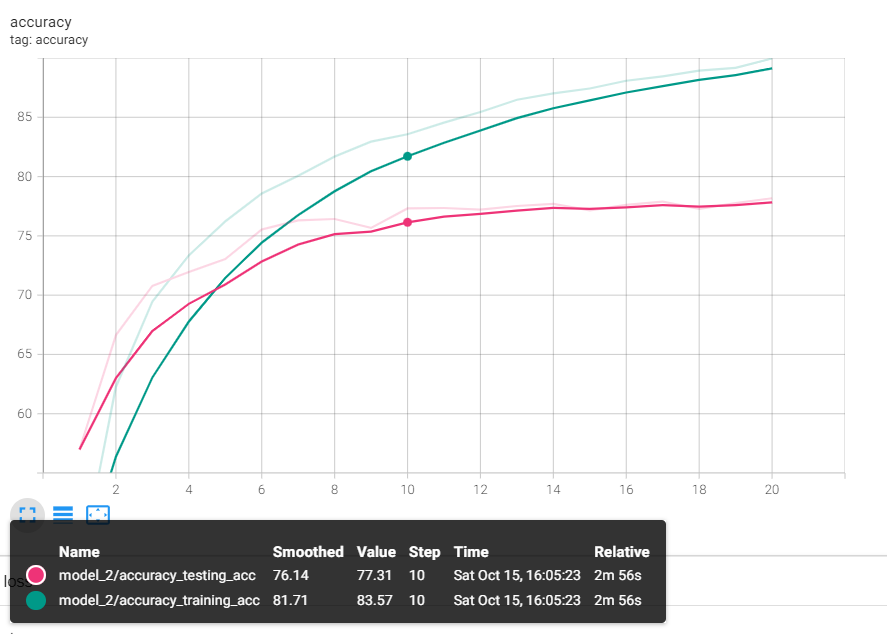

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

# Solution Task 2

I choosed a simple softmax metric for returning probability of all classes which all sums to 1. Probability of each class in one image is always in range between 0 and 1. Max probability of prediction will be as well our certainty of model prediction.

$\sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K$

Softmax function converts vector of values to vector of probabilities by 
dividing the exponential function of individual observation by sum of every exponential function of observation.


In [ ]:
class Model:
  def __init__(self, load_path: str, device: str):
    self.model = self._load_model(load_path, device)

  def predict(self, data: torch.Tensor) -> torch.Tensor:
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    return predicted

  def certainty(self, data: torch.Tensor) -> torch.Tensor:
    outputs = model(data)
    softmax = nn.Softmax(dim=-1)
    certainty = softmax(outputs.data)
    return certainty

  def _load_model(self, load_path: str, device: str) -> nn.Module:
    model = FinalModel(10)
    model.load_state_dict(torch.load(load_path, map_location=device))
    return model


In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/gdrive/')

model_path = '/content/gdrive/MyDrive/cnn_model/model'

Mounted at /content/gdrive/


In [ ]:
class_model = Model(model_path, device)

In [ ]:
# Get all certainties from test set
correct_certainties = torch.Tensor()
wrong_certainties = torch.Tensor()

for images, labels in tqdm(test_loader):
  images = images.to(device)
  labels = labels.to(device)

  predicted = class_model.predict(images)
  certainty = class_model.certainty(images).max(dim=-1).values

  correct_certainties = torch.cat((correct_certainties, certainty[(predicted == labels)]))
  wrong_certainties = torch.cat((wrong_certainties, certainty[(predicted != labels)]))

100%|██████████| 79/79 [01:08<00:00,  1.16it/s]


In [ ]:
# Create pandas DataFrame for visualisation
correct_certainties = correct_certainties.numpy()
wrong_certainties = wrong_certainties.numpy()

correct_labels = np.full((7796,), True)
wrong_labels = np.full((2204,), False)

df_correct = pd.DataFrame(columns = ['certainty', 'correct_label'], 
                          data={'certainty': correct_certainties, 'correct_label': correct_labels})
df_wrong = pd.DataFrame(columns = ['certainty', 'correct_label'], 
                          data={'certainty': wrong_certainties, 'correct_label': wrong_labels})

df_all = df_correct.append(df_wrong, ignore_index=True)

In [ ]:
df_all

,certainty,correct_label
0,0.718052,True
1,0.999813,True
2,0.982146,True
3,0.994599,True
4,0.999653,True
...,...,...
9995,0.802247,False
9996,0.773048,False
9997,0.896332,False
9998,0.808326,False


## Certainties hist

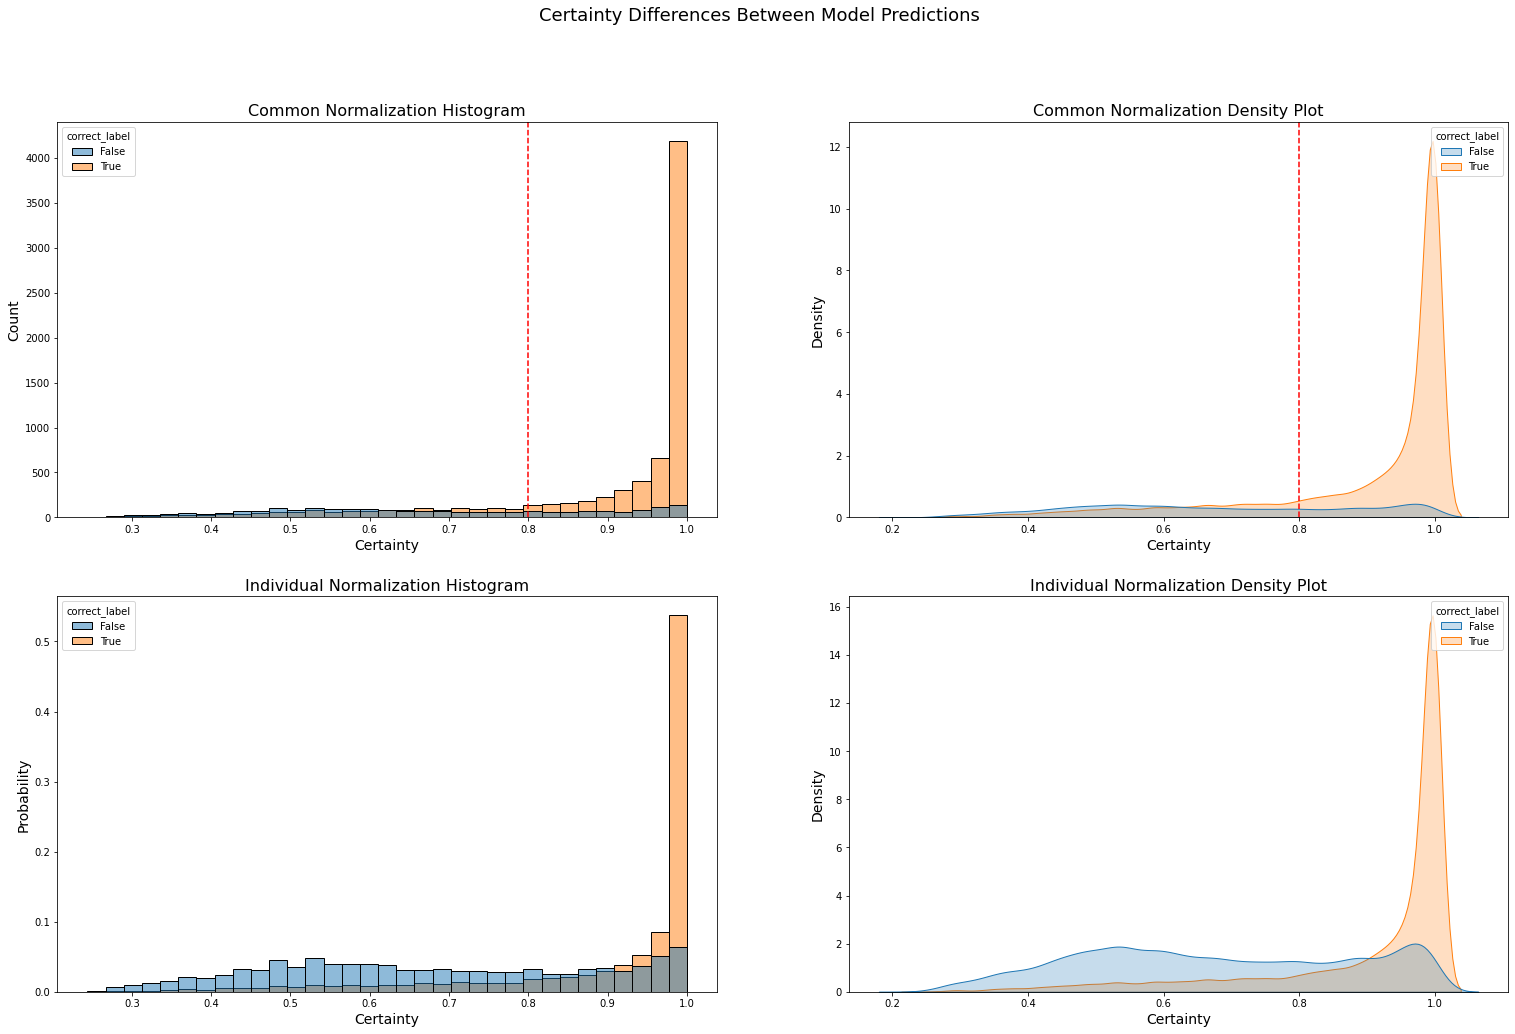

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(26,16))
axs = axs.flatten()

fig.suptitle('Certainty Differences Between Model Predictions', fontsize=18)

axs[0].set_xlabel('Certainty', fontsize=14)
axs[0].set_ylabel('Count', fontsize=14)
axs[0].set_title('Common Normalization Histogram', fontsize=16)
axs[0].axvline(x=0.8, color='r', ls='--')
sns.histplot(data = df_all, x='certainty', hue='correct_label', common_norm=True, ax=axs[0])

axs[1].set_xlabel('Certainty', fontsize=14)
axs[1].set_ylabel('Density', fontsize=14)
axs[1].set_title('Common Normalization Density Plot', fontsize=16)
axs[1].axvline(x=0.8, color='r', ls='--')
sns.kdeplot(data = df_all, x='certainty', hue='correct_label', common_norm=True, fill=True, bw_adjust=0.5, ax=axs[1])

axs[2].set_xlabel('Certainty', fontsize=14)
axs[2].set_ylabel('Probability', fontsize=14)
axs[2].set_title('Individual Normalization Histogram', fontsize=16)
sns.histplot(data = df_all, x='certainty', hue='correct_label', stat='probability', common_norm=False, ax=axs[2])

axs[3].set_xlabel('Certainty', fontsize=14)
axs[3].set_ylabel('Density', fontsize=14)
axs[3].set_title('Individual Normalization Density Plot', fontsize=16)
sns.kdeplot(data = df_all, x='certainty', hue='correct_label', common_norm=False, fill=True, bw_adjust=0.5, ax=axs[3])

plt.show()

As we can see above, 0.8 point can be a nice threshold whether to tell we are sure that prediction is correct or not. At 0.8 point we starting to have twice more true predictions than false. 

# Solution Task 3

## Code wrap up

In [26]:
class Model:
  def __init__(self, load_path: str, device: str):
    self.model = self._load_model(load_path, device)

  def predict(self, input_array: np.ndarray, normalize: bool) -> np.ndarray:
    data = self._prepare_batch(input_array, normalize)
    outputs = self.model(data)
    _, predicted = torch.max(outputs.data, 1)
    return predicted.numpy()

  def certainty(self, input_array: np.ndarray, normalize: bool) -> np.ndarray:
    data = self._prepare_batch(input_array, normalize)
    outputs = self.model(data)
    softmax = nn.Softmax(dim=-1)
    certainty = softmax(outputs.data)
    return certainty.numpy()

  def _load_model(self, load_path: str, device: str) -> nn.Module:
    model = FinalModel(10)
    model.load_state_dict(torch.load(load_path, map_location=device))
    return model

  def _prepare_batch(self, input_array: np.ndarray, normalize: bool) -> torch.Tensor:
    data_tensor = torch.from_numpy(input_array)
    if normalize:
      transform = Normalize( 
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
      )
      data_tesnsor = transform(data_tensor)
    
    return data_tensor


In [27]:
### Testing 

# model = Model(model_path, device)

# images, labels = next(iter(test_loader))

# predictions = model.predict(images.numpy(), False)
# certainties = model.certainty(images.numpy(), False)

In [31]:
# predictions

array([8, 7, 5, 7, 0, 6, 4, 4, 9, 8, 7, 0, 6, 5, 8, 2, 9, 4, 4, 9, 7, 8,
       8, 6, 2, 0, 3, 5, 8, 8, 8, 4, 7, 6, 8, 4, 8, 4, 3, 2, 7, 6, 2, 2,
       3, 9, 1, 6, 7, 0, 0, 4, 5, 7, 9, 3, 1, 2, 2, 0, 2, 7, 5, 1, 0, 1,
       8, 2, 9, 6, 5, 9, 2, 3, 6, 5, 5, 1, 1, 9, 5, 0, 7, 7, 5, 2, 9, 3,
       2, 4, 0, 2, 7, 1, 7, 5, 8, 6, 5, 4, 3, 5, 6, 9, 8, 4, 0, 8, 0, 6,
       7, 1, 2, 1, 9, 5, 6, 4, 8, 1, 3, 1, 9, 0, 2, 4, 1, 7])

In [32]:
# certainties

array([[2.93794932e-04, 7.82479569e-02, 3.16826830e-04, ...,
        9.90659231e-04, 7.05327868e-01, 1.64046228e-01],
       [2.68549366e-06, 8.24769984e-07, 1.81255182e-05, ...,
        8.58437836e-01, 4.10465155e-08, 1.94215363e-06],
       [1.03976764e-01, 2.97854800e-04, 2.67694861e-01, ...,
        6.88622296e-02, 1.03918631e-02, 2.69798067e-04],
       ...,
       [1.08685061e-04, 3.86213378e-06, 2.76248506e-03, ...,
        1.29079504e-04, 1.81128980e-05, 8.65872244e-06],
       [5.06201377e-06, 9.64601755e-01, 2.34643963e-07, ...,
        2.98492949e-07, 1.41961318e-05, 3.53647023e-02],
       [2.51097772e-02, 1.40485226e-03, 7.08313584e-02, ...,
        3.48651320e-01, 2.52244119e-02, 2.01818906e-03]], dtype=float32)